# Validation

In order to further validate the promising results of the PLM classifier on the testing data, we sought to interrogate a well-characterized microbial genome using the model. To this end, we chose to analyze the complete genome of Escherichia coli (strain K-12, substrain. MG1655, assembly ASM584v2). The RefSeq accession for this genome is GCF_000005845.2. 

For organizational purposes, all data used for model validation is placed into a subdirectory within the data directory. If you want to run this code, be sure to modify the `DATA_DIR` variable below to specify where the data will be stored on your machine.


In [4]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
# Add the selenobot/ subirectory to the module search path, so that the modules in this directory are visible from the notebook.
sys.path.append('../selenobot/')

from dataset import Dataset
from classifiers import Classifier
from utils import csv_size, dataframe_from_gff, dataframe_to_fasta, dataframe_from_m8, dataframe_from_fasta
from extend import extend
import pandas as pd
import re
from typing import NoReturn, List
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch

In [5]:
DATA_DIR = '/home/prichter/Documents/data/selenobot/validation/'

# E. coli strain K-12 substrain MG1655
genome_id = 'GCF_000005845.2' # The accession of the genome to download. 
assembly = 'ASM584v2' # The specific genome assembly.

# https://www.nature.com/articles/s41396-022-01222-x#Sec2

# Synergistota
# genome_id = 'GCA_018398915.1' 
# assembly = 'ASM1839891v1'

# Methanosarcinales archaeon 
# genome_id = 'GCA_026016205.1'
# assembly = 'ASM2601620v1'

## Downloading genome data

In [11]:
# Download and unzip the genome data from NCBI. 
! curl 'https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/{genome_id}/download?include_annotation_type=GENOME_FASTA,PROT_FASTA,GENOME_GFF' -o '{DATA_DIR}ncbi_dataset.zip'
! unzip '{DATA_DIR}ncbi_dataset.zip' -d '{DATA_DIR}'

# Create a directory to store the genome files. 
! mkdir '{DATA_DIR}{genome_id}/' 
# Move the relevant files into the new directory for organizational purposes. 
! mv '{DATA_DIR}ncbi_dataset/data/{genome_id}/genomic.gff' -t '{DATA_DIR}{genome_id}/'
! mv '{DATA_DIR}ncbi_dataset/data/{genome_id}/protein.faa' -t '{DATA_DIR}{genome_id}/'
! mv '{DATA_DIR}ncbi_dataset/data/{genome_id}/{genome_id}_{assembly}_genomic.fna' '{DATA_DIR}{genome_id}/genome.fna'

# Remove some extraneous files which were also downloaded. 
! rm '{DATA_DIR}README.md'
! rm -R '{DATA_DIR}ncbi_dataset'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  561k    0  561k    0     0   157k      0 --:--:--  0:00:03 --:--:--  157k
Archive:  /home/prichter/Documents/data/selenobot/validation/ncbi_dataset.zip
  inflating: /home/prichter/Documents/data/selenobot/validation/README.md  
  inflating: /home/prichter/Documents/data/selenobot/validation/ncbi_dataset/data/assembly_data_report.jsonl  
  inflating: /home/prichter/Documents/data/selenobot/validation/ncbi_dataset/data/GCA_026016205.1/GCA_026016205.1_ASM2601620v1_genomic.fna  
  inflating: /home/prichter/Documents/data/selenobot/validation/ncbi_dataset/data/GCA_026016205.1/protein.faa  
  inflating: /home/prichter/Documents/data/selenobot/validation/ncbi_dataset/data/GCA_026016205.1/genomic.gff  
  inflating: /home/prichter/Documents/data/selenobot/validation/ncbi_dataset/data/dataset_catalog.json  


In [12]:
def clean(path:str) -> NoReturn:
    '''Modify the format of downloaded FASTA files to standardize reading and writing FASTA files.'''
    fasta = ''
    with open(path, 'r') as f:
        lines = f.readlines()
    # In the FASTA files downloaded from NCBI, the only relevant information is right after the > character.
    # This is the GenBank protein accession, which will be called the 'id'.
    for line in lines:
        if '>' in line: # This symbol marks the beginning of a header file.
            id_ = re.search('>([^\s]+)', line).group(1)
            fasta += f'>id={id_}\n'
        else:
            fasta += line
    # This will overwrite the original file. 
    with open(path, 'w') as f:
        f.write(fasta)

In [13]:
clean(f'{DATA_DIR}{genome_id}/protein.faa')

### Truncating known selenoproteins

The E. coli genome assembly used contains three known selenoproteins: fdoG (RefSeq accession NP_418330.1), fdnG (RefSeq accession NP_415991.1) and fdhF (RefSeq accession NP_418503.1). The RefSeq accessions are found using the NCBI annotation browser for the particular E. coli genome assembly. Prior to generating the PLM embeddings, each of these sequences in the protein.faa file is truncated at the first selenocysteine residue. These sequences will act as sanity checks, ensuring that the PLM classifier is able to identify sequences known to be truncated selenoproteins. 

In [29]:
known_selenoproteins = ['NP_418330.1', 'NP_415991.1', 'NP_418503.1']

In [30]:
def truncate_selenoproteins(path:str, gene_ids:List[str]=None) -> NoReturn:
    '''Truncate the known selenoproteins stored in the input file, which are specified using the gene_ids
    parameter.'''
    # Load the selenoproteins into a pandas DataFrame. 
    df = dataframe_from_fasta(path)
    for row in df.itertuples(index=True):
        if getattr(row, 'id') in gene_ids:
            u_loc = row.seq.index('U')
            # setattr(row, 'seq', row.seq[:u_loc])
            row = row._replace(seq=row.seq[:u_loc])
            print(f"truncate_selenoproteins: Truncated {getattr(row, 'id')}.")
            df.loc[row.Index] = row[1:] # Save the edited row in the DataFrame.
    dataframe_to_fasta(df, path=path)

In [31]:
truncate_selenoproteins(f'{DATA_DIR}{genome_id}/protein.faa', gene_ids=known_selenoproteins)

truncate_selenoproteins: Truncated NP_415991.1.
truncate_selenoproteins: Truncated NP_418330.1.
truncate_selenoproteins: Truncated NP_418503.1.


## Predicting selenoproteins

### Generating PLM embeddings

Using the same procedure as was used to create embeddings for the UniProt sequences for training the classifier, embeddings are generated for all predicted genes in the model genome. The code for embedding sequence data is provided in the `embed.py` file in the `scripts` directory. The process for generating embeddings was computationally-intensive, and had to be run on an external computer cluster. The steps of the embedding algorithm, which is implemented by the `PlmEmbedder` class, are given below.

1. **Amino acid sequences are read from a FASTA file.**
2. **All non-standard amino acids were replaced with an “X”.**
3. **Sequences were sorted in ascending order according to length.** This avoids the addition of unnecessary padding. 
4. **The sequences are processed and tokenized in batches.** Processing sequences in batches enables one to generate the embeddings as quickly as possible, while also preventing the GPUs from crashing. The maximum number of sequences in any given batch is 100, the maximum number of amino acids in a batch is 4000, and any sequence longer than 1000 amino acids is processed individually. 
5. **The PLM is used to generate embeddings.** These embeddings have shape shape `(length, latent dimension)`.
6. **Each embedding is sliced according to the length of the original sequence.** This is due to the fact that part of the model output corresponds to the padding tokens, which should be excluded from the final embedding. 
7. **The embeddings are mean-pooled over sequence length.** This step standardizes the length of the embedding vectors to be of fixed dimension (the latent dimension of the PLM), which is necessary for passing them to the Selenobot linear classifier. 
The output of the steps above is data containing gene IDs, the original amino acid sequences (which may contain non-standard residues), and columns with the mean-pooled embeddings. 

There are several pre-embedded genomes available in the Google Cloud repository, which can be downloaded using the code below. 

In [ ]:
curl 'https://storage.googleapis.com/selenobot-data/{genome_id}.csv' -o '{DATA_DIR}{genome_id}.csv'

### Running the PLM classifier

The same workflow as described in the `training.ipynb` and `testing.ipynb` notebooks is used to predict selenoproteins in the model genome. First, the `proteins.faa` file, which contains the predicted amino acid sequences in the genome, is loaded into a pandas `DataFrame` and used to initialize a `Dataset` object. Then, the model’s predict method is called on the `Dataset`, generating a `TestReporter` object which stores model output. A threshold of `0.5` is applied to the model output, selecting positive classifications in which the model is over 50 percent confident. The IDs of the candidate selenoprotein sequences and the model confidence values are written to a `predictions.csv` file. 

In [26]:
df = pd.read_csv(f'{DATA_DIR}{genome_id}.csv', index_col=0)
# df = pd.read_csv(f'{DATA_DIR}../test.csv', index_col=0)
dataset = Dataset(df, embedder=None)

In [27]:
model = Classifier(latent_dim=1024, hidden_dim=512)
model.load_state_dict(torch.load(f'{DATA_DIR}../plm_model_weights.pth'))

<All keys matched successfully>

In [29]:
reporter = model.predict(dataset)

# Apply the threshold to model outputs, and find the sequence IDs in the proteome for which the prediciton is 1.
predictions = df[reporter.apply_threshold(threshold=0.5) == 1]
# Add the model confidences to the DataFrame. 
predictions['confidence'] = reporter.outputs[reporter.apply_threshold(threshold=0.5) == 1]

# Print some information about the hits: how many hits, and how confident is the model that they are truncated selenoproteins?
print('Number of predicted selenoproteins:', len(predictions))
print('Model confidence for each predicted selenoprotein:', predictions.confidence.values)

# Write the predicted selenoproteins to a file, along with the model confidence. 
predictions[['id', 'confidence']].set_index('id').to_csv(f'{DATA_DIR}{genome_id}/predictions.csv')

Number of predicted selenoproteins: 3
Model confidence for each predicted selenoprotein: [0.9749483  0.8699334  0.57687116]


## Extending flagged sequences

First, the data in the genomic.gff file (e.g.  the start and stop position of each sequence in the genome, as well as whether the gene is read from the forward or reverse strand) is merged with the DataFrame containing the predicted selenoproteins. This information is used to extend each amino acid sequence to the next stop codon using the following procedure.

1. **Read in the complete genome sequence from the genome.fna file.**
2. **The terminal location of the sequence is located in the genome, and incremented from right to left (reverse) or left to right (forward) until the next stop codon is encountered.** Valid stop codons are TAA, TAG and TGA, and their reversed equivalents.
3. **The new gene coordinates, the original stop codon, etc. are stored in the input DataFrame.** 
5. **Each extended nucleotide sequence is translated to a sequence of amino acids.** This is done using the `BioPython` `Seq` module. The translation utilities provided by `BioPython` do not support non-standard amino acids, so the selenocysteine residue (U) is added manually after the translation step. 

The extended sequences are written to a FASTA file called `query.faa`, which is used during homology search with MMSeqs2. In addition to the extended sequences, this file contains the following information in the header fields of each entry. 
1. **gene_id** The RefSeq gene ID of the query sequence (e.g. fdoG)
2. **id** The GenBank unique identifier of the coding sequence. 
3. **nt_ext** How much the sequence was extended, in terms of the number of nucleotides. 
4. **aa_ext** How much the sequence was extended, in terms of the number of amino acids. 
5. **nt_start** The start location of the gene encoding the protein. 
6. **nt_stop** The stop location of the gene encoding the protein. 
7. **reverse** Whether or not the gene is read from the forward or reverse strand. Either True or False. 
8. **u_codon** The codon encoding the putative selenocysteine residue (i.e. the original stop codon). 


In [30]:
predictions = pd.read_csv(f'{DATA_DIR}{genome_id}/predictions.csv') # Read in the model predictions. 
# Add the information from the GFF file to the DataFrame of predicted selenoproteins. 
gff_df = dataframe_from_gff(f'{DATA_DIR}{genome_id}/genomic.gff') 
predictions = predictions.merge(gff_df, on='id')

print('Predicted selenoprotein IDs:\n' + '\n'.join([f"{getattr(row, 'id')} ({row.gene_id})" for row in predictions.itertuples()]))

Predicted selenoprotein IDs:
UZE92041.1 (None)
UZE92443.1 (None)
UZE92782.1 (None)


In [8]:
def load_genome(path:str) -> str:
    '''Load in the complete nucleotide sequence of the genome.
    
    :param path: A FASTA file from NCBI which contains a complete genome. 
    :return: A string of nucleotides. 
    '''
    with open(path, 'r') as f:
        lines = f.read().splitlines()[1:] # Skip the header line. 
        seq = ''.join(lines)
    return seq

In [24]:
# Read in the complete genome of the model organism. 
genome = load_genome(f'{DATA_DIR}{genome_id}/genome.fna')

# QVL37563.1, QVL37671.1 do not have a valid start codon, so removing. 
predictions = predictions[~predictions['id'].str.match('QVL37563.1')]
predictions = predictions[~predictions['id'].str.match('QVL37671.1')]

# Extend the predictions, and write them to a query.faa file for use with MMSeqs.
predictions = extend(predictions, genome)
dataframe_to_fasta(predictions, f'{DATA_DIR}{genome_id}/query.faa')

## Homology search against GTDB

The MMSeqs2 tool is used to search for sequences homologous to the extended candidate selenoproteins in the `query.faa` file. This search was performed on a remote computing cluster, and a full description of the procedure is provided in the Methodology document. The output of the homology search is a file where each row represents a single query-target match. The table has twelve columns:

1. **The header from the `query.fasta` file.** This contains information like the query gene ID, sequence length, etc.
2. **GTDB identifiers for the target sequence.**
3. **Sequence identity.**
4. **Alignment length.**
5. **Number of mismatches.**
6. **Number of gap openings.**
7. **The start position of the matching domain in the query sequence.** This is given in terms of the number of amino acids from the start of the query sequence.
8. **The stop position of the matching domain in the query sequence.** This is given in terms of the number of amino acids from the start of the query sequence.
9. **The start position of the matching domain in the target sequence.** This is given in terms of the number of amino acids from the start of the query sequence.
10. **The stop position of the matching domain in the target sequence.** This is given in terms of the number of amino acids from the start of the query sequence.
11. **E-value.** This is the “expect value,” and reflects the likelihood of the sequence match occurring by chance.
12. **Bit score.** This score is calculated from a formula that takes into account the alignment of similar or identical residues, as well as any gaps introduced to align the sequences. 

### Downloading sequences for MMSeqs2 hits

The output file produced by MMSeqs2 does not contain the amino acid sequences for the matching targets. These sequences are stored in a remote SQL database hosted by Caltech, and were downloaded using the [Find-A-Bug Python API](https://github.com/pipparichter/find-a-bug-api). 

In [1]:
# Install the Find-A-Bug API.
# ! pip install -e /home/prichter/Documents/find-a-bug-api

In [2]:
import fabapi # Import the Find-A-Bug Python API

In [16]:
# Load in the MMSeqs results, dropping the two columns which are not populated by the program.
mmseqs_df = dataframe_from_m8(f'{DATA_DIR}{genome_id}/results.m8').drop(columns=['query_align_seq', 'target_align_seq'])
print(f'Number of MMSeqs hits for {genome_id} in the GTDB database:', len(mmseqs_df))

Number of MMSeqs hits for GCA_026016205.1 in the GTDB database: 15357


In [8]:
# Download the target sequences using the Find-A-Bug API.
target_seqs = []
for target_id in mmseqs_df.target_id:
    # get_sequence_with_gene_id returns a DataFrame, so we need to extract the sequence.
    seq = fabapi.get_sequence_with_gene_id(target_id).seq.item()
    target_seqs.append(seq)
mmseqs_df['target_seq'] = target_seqs

In [18]:
# Write the new DataFrame (with sequences added) to a file to avoid re-generating in case the kernel crashes.
mmseqs_df.set_index('query_id').to_csv(f'{DATA_DIR}{genome_id}/results.csv')

### Filtering MMSeqs2 hits



In [81]:
mmseqs_df = pd.read_csv(f'{DATA_DIR}{genome_id}/results.csv')

In [82]:
def check_hit_overlap(row):
    '''Check if a particular MMSeqs hit spans the stop codon in the query sequence.'''
    # We want the start of the hit to precede the U codon, and the end of the hit
    # to lie in the extended region. 
    u_pos = int(row.query_aa_length) - (int(row.query_nt_ext) // 3)
    return (u_pos > row.target_align_start) and (u_pos < row.target_align_stop)

In [83]:
# We only care about the hits which overlap on the extended region.
print('Number of hits before filtering by overlap:', len(mmseqs_df))
mmseqs_df = mmseqs_df[mmseqs_df.apply(check_hit_overlap, axis=1)]
print('Number of hits after filtering by overlap:', len(mmseqs_df))

Number of hits before filtering by overlap: 15357
Number of hits after filtering by overlap: 80


Mean length of hits for UZE92782.1: 385.18666666666667


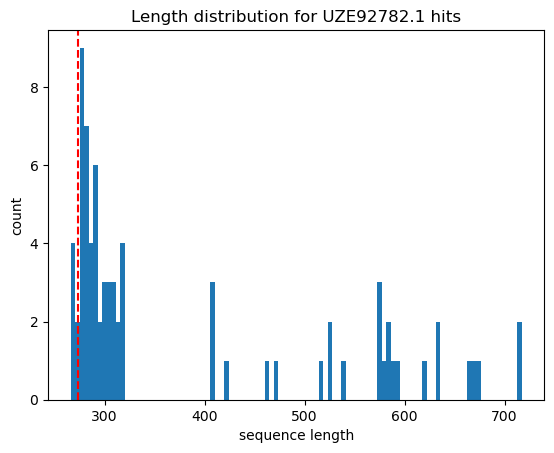

In [84]:
# Now, we want to visualize the length distribution of the MMSeqs2 hits to filter by length. 
query_id = 'UZE92782.1'
# query_id = 'UZE92041.1'

fig, ax = plt.subplots()
hit_lengths = mmseqs_df[mmseqs_df.query_id.str.match(query_id)].target_seq.apply(lambda s : len(s.replace('*', '')))
_, bins, _ = ax.hist(hit_lengths, bins=100)
print(f'Mean length of hits for {query_id}:', np.mean(hit_lengths))

ymin, ymax = ax.get_ylim()
query_length = mmseqs_df[mmseqs_df.query_id.str.match(query_id)].query_aa_length.iloc[0] 
ax.axvline(int(query_length), ymin=ymin, ymax=ymax, c='red', ls='--')

ax.set_title(f'Length distribution for {query_id} hits')
ax.set_ylabel('count')
ax.set_xlabel('sequence length')

plt.show()

In [85]:
# Based on the sequence length plot, we can select reasonable boundaries for the subsequent BLAST search. 
# There seems to be more hits for the sample UZE92041.1, so we will focus on that. 
mmseqs_df = mmseqs_df[mmseqs_df.query_id.str.match('UZE92782.1')]
mmseqs_df = mmseqs_df[mmseqs_df.target_seq.apply(len) < 400]

In [100]:
print('Sequences remaining after filter:', len(mmseqs_df))
dataframe_to_fasta(mmseqs_df.rename(columns={'target_seq':'seq'}), f'{DATA_DIR}{genome_id}/blast_target.faa')

blast_query_df = dataframe_from_fasta(f'{DATA_DIR}{genome_id}/query.faa')
blast_query_df = blast_query_df[blast_query_df['id'].str.match(query_id)]
dataframe_to_fasta(blast_query_df, f'{DATA_DIR}{genome_id}/blast_query.faa')

Sequences remaining after filter: 49


## Aligning homologs against extended sequences

In [ ]:
# Install the BLAST command-line tool for Linux, and unzip the file in your home directory. 
curl https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/ncbi-blast-2.15.0+-x64-linux.tar.gz  -o /home/prichter/
tar /home/prichter/zxvpf ncbi-blast-2.15.0+-x64-linux.tar.gz 

In [106]:
# Set the path to the blast alignment command. 
blastp_cmd = '/home/prichter/ncbi-blast-2.15.0+/bin/blastp'
# Define a custom TSV output format for the BLAST alignment. 
outfmt = '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qseq sseq'

In [108]:
! '{blastp_cmd}' -subject '{DATA_DIR}{genome_id}/blast_target.faa' -query '{DATA_DIR}{genome_id}/blast_query.faa' -outfmt '{outfmt}' -out '{DATA_DIR}{genome_id}/blast_results.m8'

In [120]:
blastp_df = dataframe_from_m8(f'{DATA_DIR}{genome_id}/blast_results.m8')
blastp_df.head()

,percentage_identical,align_length,num_mismatches,num_gap_openings,query_align_start,query_align_stop,target_align_start,target_align_stop,e_value,bit_score,...,query_scaffold_id,query_feature,query_nt_start,query_nt_stop,query_reverse,query_frame,query_gene_id,query_nt_ext,query_aa_length,query_u_codon
0,33.526,173,113,1,36,208,116,286,1.900000e-34,118.0,...,CP061209.1,CDS,182508,183327,True,0,None,24,273,TAA
1,23.626,182,131,3,62,241,102,277,4.110000e-18,73.6,...,CP061209.1,CDS,182508,183327,True,0,None,24,273,TAA
2,24.503,151,110,2,62,210,123,271,5.230000e-17,70.1,...,CP061209.1,CDS,182508,183327,True,0,None,24,273,TAA
3,26.347,167,108,4,62,217,114,276,9.940000e-17,69.3,...,CP061209.1,CDS,182508,183327,True,0,None,24,273,TAA
4,22.013,159,115,2,31,189,106,255,1.270000e-16,69.3,...,CP061209.1,CDS,182508,183327,True,0,None,24,273,TAA


In [112]:
print('Maximum sequence identity:', max(blastp_df.percentage_identical))
print('Minimum sequence identity:', min(blastp_df.percentage_identical))
print('Mean sequence identity:', blastp_df.percentage_identical.mean())

Maximum sequence identity: 33.526
Minimum sequence identity: 19.512
Mean sequence identity: 23.971540000000005


In [122]:
for target_id in blastp_df.target_id:
    print(target_id)

JAFRMD010000040.1_2
CACXCN010000042.1_15
CAISVC010000334.1_1
SLMV01000216.1_7
CAJORE010000133.1_2
JAFQMU010000191.1_11
JAFTCE010000087.1_14
CACWQW010000002.1_20
SKJJ01000116.1_9
JADFVM010000040.1_20
NZ_AUBP01000002.1_72
SLGS01000155.1_2
WQRV01000016.1_6
JAAYOY010000184.1_5
JAABTT010000029.1_23
JACRNJ010000069.1_9
JACRCM010000168.1_26
MHDO01000099.1_5
JACQXH010000220.1_6
VGSO01000021.1_8
JACNJG010000027.1_7
NZ_ARQF01000020.1_864
JACQQJ010000126.1_9
JACRPW010000006.1_35
QKEJ01000196.1_5
QKEJ01000196.1_5
MGRL01000091.1_9
JAAYGN010000044.1_4
DTGR01000225.1_7
DNJG01000034.1_8
MNZR01000272.1_3
CABKMN010000070.1_11
NZ_AUCY01000041.1_19
LR026961.1_3008
NZ_AULM01000012.1_90
NZ_JYNO01000004.1_377
DXFI01000243.1_4
JAHJUF010000009.1_1
DBMO01000023.1_15
JACNJD010000247.1_3
NZ_JACHGO010000006.1_23
LUZZ01000011.1_8
PQXE01000019.1_20
DSCZ01000118.1_2
WGDC01000016.1_26
DREN01000450.1_5
CAJUHZ010000014.1_8
PQXD01000004.1_69
JAGYNZ010000008.1_28
DTYO01000048.1_3
